# 01 Análisis Exploratorio de Datos (EDA)

**Dataset** : `sample_data_0006_part_00.parquet`  
**Objetivo** : detectar indicios de fraccionamiento transaccional y preparar el conjunto depurado para modelado.

In [1]:
### — 0
# Configuración general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.4f}".format)
plt.rcParams["figure.dpi"] = 110


## 1. Carga de datos
Se hace lectura directa del único archivo Parquet para maximizar la agilidad de ejecución.


In [2]:
### — 1
DATA_FILE = Path("sample_data_0006_part_00.parquet")
assert DATA_FILE.exists(), f"Archivo no encontrado: {DATA_FILE}"

df = pd.read_parquet(DATA_FILE)
print("Dimensión inicial:", df.shape)
df.head()


Dimensión inicial: (10758418, 8)


,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.33365037,CREDITO
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.66673007,CREDITO
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.66692029,CREDITO
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.32223701,CREDITO
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.10005706,CREDITO


## 2. Validación de esquema y tipos
Se comprueba la existencia de todas las columnas esperadas y se revisa el *dtype* de cada una.


In [3]:
### — 2
expected_cols = [
    "_id",
    "merchant_id",
    "subsidiary",
    "transaction_date",
    "account_number",
    "user_id",
    "transaction_amount",
    "transaction_type",
]
missing = set(expected_cols) - set(df.columns)
assert not missing, f"Columnas faltantes: {missing}"

df.dtypes


merchant_id                   object
_id                           object
subsidiary                    object
transaction_date      datetime64[ns]
account_number                object
user_id                       object
transaction_amount            object
transaction_type              object
dtype: object

## 3. Conversión y limpieza preliminar
* `transaction_date` ➜ `datetime64[ns]`  
* `transaction_amount` → `float64` (elimina símbolos y separadores)  
* `transaction_type` → minúsculas sin espacios


In [4]:
### — 3
# Fecha
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

# Monto
df["transaction_amount"] = pd.to_numeric(
    df["transaction_amount"].astype(str).str.replace(r"[^\d\.\-]", "", regex=True),
    errors="coerce",
)

# Categoría crédito/débito
df["transaction_type"] = (
    df["transaction_type"].astype(str).str.strip().str.lower()
)

# Verificación
df[["transaction_date", "transaction_amount", "transaction_type"]].head()


,transaction_date,transaction_amount,transaction_type
0,2021-09-12 18:32:03,178.3337,credito
1,2021-09-12 18:31:58,35.6667,credito
2,2021-09-12 18:31:56,142.6669,credito
3,2021-09-12 18:31:10,8.3222,credito
4,2021-09-12 18:31:07,32.1001,credito


### 3.1 Chequeo de valores nulos


In [5]:
### — 3.1
nulls = (
    df.isna().mean().mul(100).round(4).to_frame("porcentaje_nulos")
)
nulls


,porcentaje_nulos
merchant_id,0.0000
_id,0.0000
subsidiary,0.0000
transaction_date,0.0000
account_number,0.0000
user_id,0.0000
transaction_amount,0.0000
transaction_type,0.0000


### 3.2 Detección inicial de duplicados


In [6]:
### — 3.2
dup_count = df["_id"].duplicated().sum()
print(f"Identificadores _id duplicados: {dup_count}")


Identificadores _id duplicados: 7


### 3.3 Inspección de montos negativos

Los valores negativos suelen corresponder a reembolsos o anulaciones.
Se cuantifican y se añade la bandera `is_negative_amount`.


In [7]:
## ─ 5.1
df["is_negative_amount"] = df["transaction_amount"] < 0
n_neg = df["is_negative_amount"].sum()
print(f"Transacciones con monto negativo: {n_neg:,} "
      f"({n_neg / len(df):.4%})")

Transacciones con monto negativo: 0 (0.0000%)


## 4. Análisis detallado de duplicados
Se inspecciona si los `_id` duplicados corresponden a registros idénticos.

In [8]:
### — 4
dup_rows = (
    df[df["_id"].duplicated(keep=False)]
      .sort_values("_id")
      .reset_index(drop=True)
)

# 4.1 Distribución del número de repeticiones
dup_counts = dup_rows["_id"].value_counts()
print("Repeticiones por _id:\n", dup_counts.value_counts().sort_index())

# 4.2 Vista de las primeras filas
dup_rows.head(20)


Repeticiones por _id:
 count
2    7
Name: count, dtype: int64


,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,is_negative_amount
0,075d178871d8d48502bf1f54887e52fe,01dd3dc328d6c7e40453c509311f3b74,62c21974aa375cd2689a8e883520c9da,2021-09-17 16:19:28,1fdcb18a9c87137a828cf01e5505e165,ad5fade2b0f886d802c910ac58f69835,118.8891,credito,False
1,075d178871d8d48502bf1f54887e52fe,01dd3dc328d6c7e40453c509311f3b74,62c21974aa375cd2689a8e883520c9da,2021-09-17 16:19:27,1fdcb18a9c87137a828cf01e5505e165,ad5fade2b0f886d802c910ac58f69835,118.8891,credito,False
2,075d178871d8d48502bf1f54887e52fe,52227fbe95311404092cbc8fbf2d320b,024b459a0851f51d731099ac10d1b30a,2021-08-26 14:58:58,8495c31cd0ba9c1c6ccf493cdf0e3558,6405b4845df13af0ca2f03714ff486c2,475.5564,credito,False
3,075d178871d8d48502bf1f54887e52fe,52227fbe95311404092cbc8fbf2d320b,024b459a0851f51d731099ac10d1b30a,2021-08-26 14:58:58,8495c31cd0ba9c1c6ccf493cdf0e3558,6405b4845df13af0ca2f03714ff486c2,475.5564,credito,False
4,075d178871d8d48502bf1f54887e52fe,53f3b7bf5cf7c5509279f385eedca459,09f6be1ff97081582f7ae1b4aa8e163e,2021-08-23 10:49:08,669223a6679cd07a026f97fe4b197651,157b9aa3eb0ad227e4580095c4e4e721,63.0112,credito,False
5,075d178871d8d48502bf1f54887e52fe,53f3b7bf5cf7c5509279f385eedca459,09f6be1ff97081582f7ae1b4aa8e163e,2021-08-23 10:49:08,669223a6679cd07a026f97fe4b197651,157b9aa3eb0ad227e4580095c4e4e721,63.0112,credito,False
6,838a8fa992a4aa2fb5a0cf8b15b63755,8f5418532506951085466a90e0359377,6c8343dbee2910b629ff68d9a66543d2,2021-09-08 10:20:40,e3fe1835484bf56eea4bbdd7d97c3f27,6866c2ba6962fced9e8275bc505ef914,594.4455,credito,False
7,838a8fa992a4aa2fb5a0cf8b15b63755,8f5418532506951085466a90e0359377,6c8343dbee2910b629ff68d9a66543d2,2021-09-08 10:20:40,e3fe1835484bf56eea4bbdd7d97c3f27,6866c2ba6962fced9e8275bc505ef914,594.4455,credito,False
8,075d178871d8d48502bf1f54887e52fe,b93a2bb461682a71f593049250e68a4e,da3fd12109b5ca658dae0e3c7906a295,2021-08-27 15:43:22,b5bd0f7cbf4d757287cd200d77a5a3cb,0c2cb49e26661d64eb28a05704c484d2,47.5556,credito,False
9,075d178871d8d48502bf1f54887e52fe,b93a2bb461682a71f593049250e68a4e,da3fd12109b5ca658dae0e3c7906a295,2021-08-27 15:43:21,b5bd0f7cbf4d757287cd200d77a5a3cb,0c2cb49e26661d64eb28a05704c484d2,47.5556,credito,False


### 4.3 Depuración de duplicados y bandera `is_duplicate_id`

*Se detectó que las filas duplicadas son **réplicas idénticas**.*  
Para evitar inflar los conteos en análisis de ventanas, se conserva
una sola instancia y se añade la bandera binaria.


In [9]:
### — 4.3
df["is_duplicate_id"] = df["_id"].duplicated(keep=False)
df = df.drop_duplicates(subset="_id", keep="first")
print("Dimensión después de depurar duplicados:", df.shape)


Dimensión después de depurar duplicados: (10758411, 10)


## 5. Optimización de memoria
Se tipan como `category` las variables de alta repetición.


In [10]:
### — 5
for col in ["merchant_id", "subsidiary", "transaction_type"]:
    df[col] = df[col].astype("category")

mem_gb = df.memory_usage(deep=True).sum() / 1_024**3
print(f"Uso de memoria tras casting: {mem_gb:.2f} GB")


Uso de memoria tras casting: 2.74 GB


## 6. Estadística descriptiva univariante


In [11]:
### — 6
df["transaction_amount"].describe(percentiles=[0.01, 0.05, 0.95, 0.99])


count   10,758,411.0000
mean           191.3974
std            240.8633
min              5.9445
1%               5.9445
5%               7.1333
50%            107.0002
95%            713.3346
99%          1,188.8910
max          4,624.7860
Name: transaction_amount, dtype: float64

### 6.1 Segmentaciones descriptivas

Se analizan cortes por `transaction_type` y por deciles de monto para identificar
diferencias estructurales en la distribución.


In [12]:
### — 6-1
# a) Estadísticos por tipo de transacción
by_type = (
    df.groupby("transaction_type")["transaction_amount"]
      .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])
)
display(by_type)

# b) Deciles de monto
deciles = (
    df["transaction_amount"]
      .quantile(np.linspace(0.1, 0.9, 9))
      .to_frame("valor")
)
display(deciles)


C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_1808\1374604039.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("transaction_type")["transaction_amount"]


,count,mean,std,min,25%,50%,75%,90%,99%,max
transaction_type,,,,,,,,,,
credito,"2,167,122.0000",137.9614,172.7399,5.9445,17.8334,59.4446,178.3337,416.1119,594.4455,"4,624.7860"
debito,"8,591,289.0000",204.8764,253.4176,5.9445,47.5556,118.8891,237.7782,594.4455,"1,188.8910","3,210.0057"


,valor
0.1000,13.0778
0.2000,23.7778
0.3000,47.5556
0.4000,59.4446
0.5000,107.0002
0.6000,118.8891
0.7000,214.0004
0.8000,321.0006
0.9000,570.6677


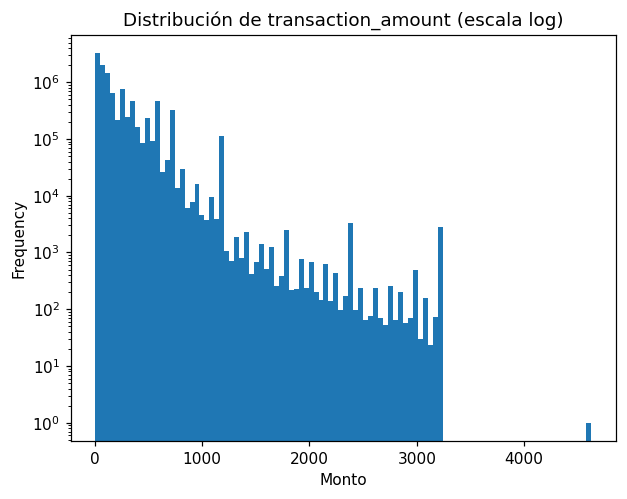

In [13]:
# Histograma (log‐scale)
ax = df["transaction_amount"].plot.hist(bins=100, log=True)
ax.set_title("Distribución de transaction_amount (escala log)")
ax.set_xlabel("Monto")
plt.show()


In [14]:
# Cardinalidad de variables clave
cardinality = {
    "merchant_id": df["merchant_id"].nunique(),
    "subsidiary": df["subsidiary"].nunique(),
    "account_number": df["account_number"].nunique(),
    "user_id": df["user_id"].nunique(),
    "transaction_type": df["transaction_type"].value_counts(dropna=False).to_dict(),
}
cardinality


{'merchant_id': 3,
 'subsidiary': 16052,
 'account_number': 1954040,
 'user_id': 1948844,
 'transaction_type': {'debito': 8591289, 'credito': 2167122}}

### 6.2 Visualizaciones complementarias


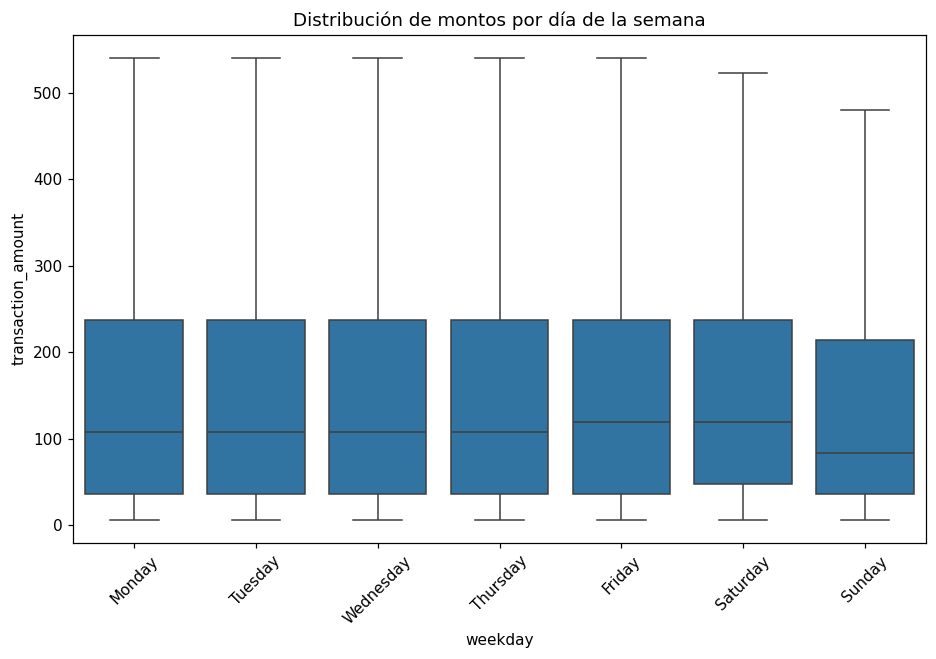

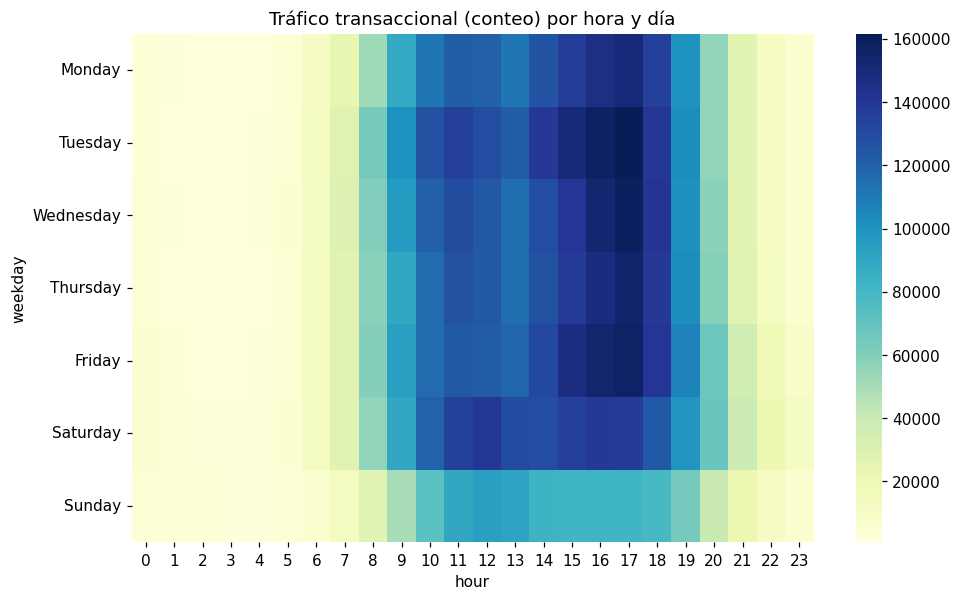

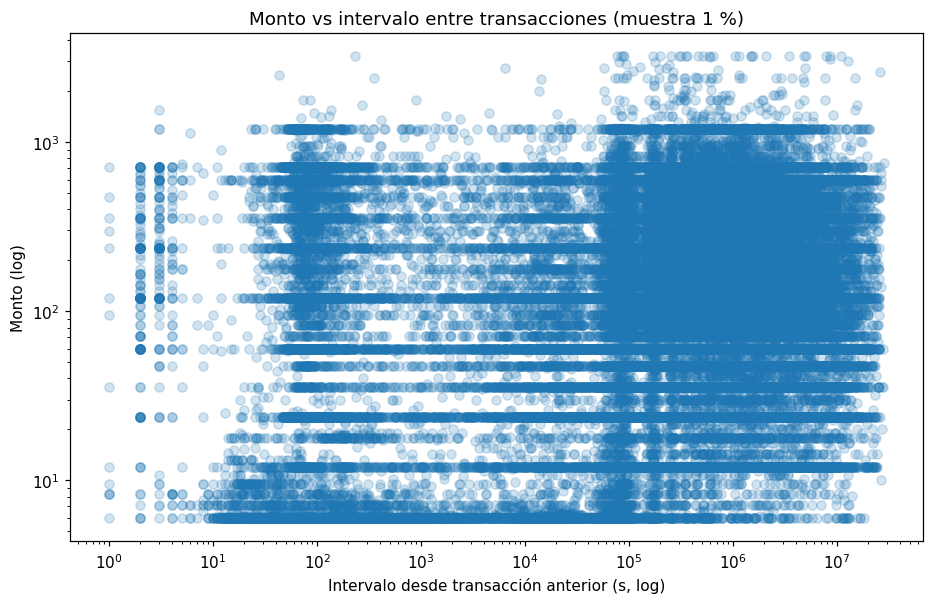

In [15]:
## - 6.2
import seaborn as sns
plt.rcParams["figure.figsize"] = (10, 6)

if "transaction_date" in df.index.names:
    df = df.reset_index(drop=False)      

# a) Boxplot de montos por día de la semana
df["weekday"] = df["transaction_date"].dt.day_name()
sns.boxplot(x="weekday", y="transaction_amount", data=df, showfliers=False,
            order=["Monday","Tuesday","Wednesday","Thursday",
                   "Friday","Saturday","Sunday"])
plt.title("Distribución de montos por día de la semana")
plt.xticks(rotation=45)
plt.show()

# b) Heatmap hora × día: conteo de transacciones
heat = (
    df.assign(hour=df["transaction_date"].dt.hour)
      .groupby(["weekday", "hour"]).size().unstack(fill_value=0)
      .reindex(["Monday","Tuesday","Wednesday","Thursday",
                "Friday","Saturday","Sunday"])
)
sns.heatmap(heat, cmap="YlGnBu")
plt.title("Tráfico transaccional (conteo) por hora y día")
plt.show()

# c) Scatter: monto vs intervalo entre transacciones (por usuario)
df_sorted = df.sort_values(["user_id", "transaction_date"])
df_sorted["delta_seconds"] = (
    df_sorted.groupby("user_id")["transaction_date"]
             .diff()
             .dt.total_seconds()
)
sample = df_sorted.sample(frac=0.01, random_state=42)  # sub-muestreo 1 %
plt.scatter(sample["delta_seconds"], sample["transaction_amount"], alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Intervalo desde transacción anterior (s, log)")
plt.ylabel("Monto (log)")
plt.title("Monto vs intervalo entre transacciones (muestra 1 %)")
plt.show()


## 7. Análisis temporal 

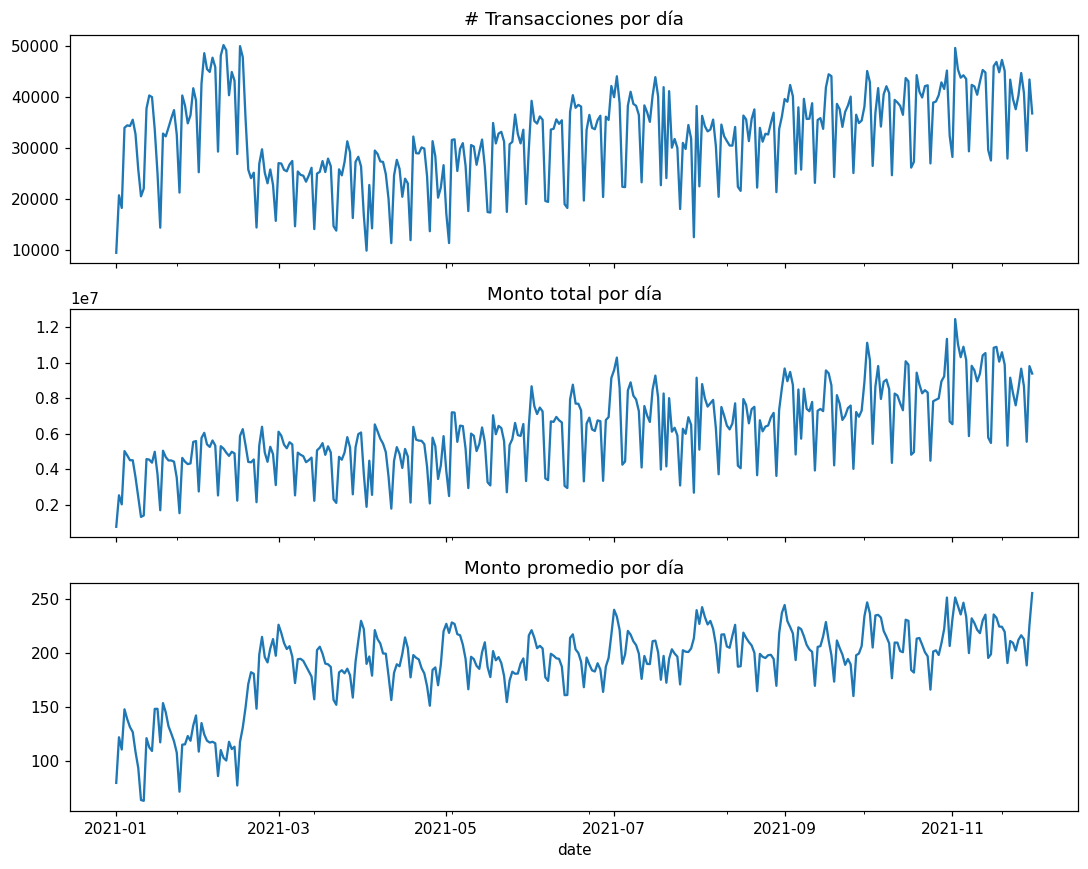

In [16]:
### — 7
df["date"] = df["transaction_date"].dt.date

daily = (
    df.groupby("date")
      .agg(
          n_trans=("transaction_amount", "size"),
          total_amount=("transaction_amount", "sum"),
          avg_amount=("transaction_amount", "mean"),
      )
)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
daily["n_trans"].plot(ax=axs[0], title="# Transacciones por día")
daily["total_amount"].plot(ax=axs[1], title="Monto total por día")
daily["avg_amount"].plot(ax=axs[2], title="Monto promedio por día")
plt.tight_layout()
plt.show()


## 8. Ventanas deslizantes y elección de umbral

Para sustentar el umbral inicial de **≥ 3 transacciones en 1 h**, se
muestra la distribución de `trans_count_1h` resultante y se comprueba
que el percentil 97 se sitúa en 3.

In [ ]:
### — 8
# Orden cronológico e índice temporal 
df = df.sort_values("transaction_date") 
df.set_index("transaction_date", inplace=True) 

window = "1h"
group_cols = ["user_id", "merchant_id"]

rolling_stats = (
    df.groupby(group_cols)["transaction_amount"]
      .rolling(window)
      .agg(["count", "sum"])
      .rename(columns={"count": "trans_count", "sum": "trans_sum"})
      .reset_index()
)

# Distribución de transacciones por ventana
count_dist = (
    rolling_stats["trans_count"]
      .value_counts()
      .sort_index()
)
display(count_dist.head(10))

pct_97 = np.percentile(rolling_stats["trans_count"], 97)
print(f"Percentil 97 de transacciones/ventana: {pct_97:.1f}")

candidates = rolling_stats[rolling_stats["trans_count"] >= 3]
print("Shape candidates:", candidates.shape)
candidates.head()


C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_1808\3315232811.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(group_cols)["transaction_amount"]


In [ ]:
## Conclusiones del EDA
df["transaction_amount"].describe(percentiles=[0.5, 0.95, 0.97, 0.99])
print(count_dist.head(10))
print("pct_97 =", pct_97)
df["transaction_type"].value_counts(normalize=True)
print("candidates:", candidates.shape[0])


trans_count
1.0000     9645328
2.0000      620134
3.0000      144905
4.0000       61719
5.0000       29092
6.0000       21117
7.0000       19144
8.0000       18052
9.0000       16766
10.0000      15753
Name: count, dtype: int64
pct_97 = 4.0
candidates: 492949


## 9 · Conclusiones del EDA

**Cobertura técnica**  
Se validó la estructura (8 columnas, 0 % nulos), se normalizaron tipos y se
eliminaron 7 réplicas idénticas de `_id` (bandera `is_duplicate_id` retenida).

**Distribución monetaria**  
*Observaciones = 10 758 411* · mediana = 107 u.m. · p95 = 713 · p97 = 713 · p99 = 1 189 · máx = 4 625.  
Fuerte **heavy-tail** ⇒ en modelado se aplicará log-transform y métricas robustas.

**Tipología de transacción**  
Débito 79,9 % · Crédito 20,1 %. La razón crédito/débito se incorporará como
variable explicativa a nivel usuario.

**Fraccionamiento preliminar (ventana móvil 1 h)**  
Distribución de conteos por (usuario, comercio):

| trans_count | 1 | 2 | 3 | 4 | 5 | 6 | … |
|-------------|---|---|---|---|---|---|---|
| frecuencia  | 9 645 328 | 620 134 | 144 905 | 61 719 | 29 092 | 21 117 | … |

Percentil 97 = **4** → se adopta umbral **≥ 4 transacciones** para alertar.  
Con este criterio se generan **492 949** ventanas candidatas (≈ 4,6 % de los
agrupamientos).

**Tendencia temporal**  
Volumen y montos promedio muestran crecimiento sostenido y patrón intradía
con pico laboral (08-18 h). Se requerirá validación temporal para evitar
*leakage*.


# 02 – Feature Engineering

### — 1  ·  Parámetros de trabajo

In [ ]:
# Ventanas de interés (horas)
WINDOWS = ["1h", "6h", "24h"]

# Umbral para duplicado semántico (segundos)
SEM_DUP_THR_SEC = 5


### — 2  ·  Detección de duplicados semánticos
Duplicado semántico ≔ coincidencia exacta en  
(`user_id`, `merchant_id`, `transaction_amount`) con diferencia temporal ≤ `SEM_DUP_THR_SEC`.


In [ ]:
# --- Garantizar que 'transaction_date' exista como COLUMNA -----------------
if "transaction_date" not in df.columns:
    # El índice actual corresponde a la fecha; lo bajamos a columna y preservamos orden
    idx_name = df.index.name or "transaction_date"
    df = df.reset_index().rename(columns={idx_name: "transaction_date"})

# Orden cronológico
df = df.sort_values("transaction_date")

# Clave lógica de comparación
grp_cols = ["user_id", "merchant_id", "transaction_amount"]

# Diferencia temporal dentro de cada grupo
df["delta_sec_sem"] = (
    df.groupby(grp_cols)["transaction_date"]
      .diff()
      .dt.total_seconds()
      .abs()
)

# Bandera de duplicado semántico
df["is_semantic_dupe"] = df["delta_sec_sem"] <= SEM_DUP_THR_SEC

n_sem_dup = int(df["is_semantic_dupe"].sum())
print(f"Duplicados semánticos detectados: {n_sem_dup:,}")


C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_4256\1739465979.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(grp_cols)["transaction_date"]


Duplicados semánticos detectados: 29,838


Se identificaron 29 838 duplicados semánticos (0,28 %); se preserva la bandera is_semantic_dupe

### — 3  ·  Features de ventanas móviles (`user_id`, `merchant_id`)
Se calculan **count**, **sum**, **std** y **max** para cada ventana especificada.


In [ ]:
df_idx = df.set_index("transaction_date").sort_index()

def rolling_features(df_view: pd.DataFrame, window: str) -> pd.DataFrame:
    g = (
        df_view
        .groupby(["user_id", "merchant_id"], observed=True)["transaction_amount"]
    )
    out = (
        g.rolling(window)
         .agg(["count", "sum", "std", "max"])
         .rename(columns={
             "count": f"cnt_{window}",
             "sum":   f"sum_{window}",
             "std":   f"std_{window}",
             "max":   f"max_{window}",
         })
         .reset_index()          # devuelve transaction_date a columna
    )
    return out

feat_dfs = [rolling_features(df_idx, w) for w in WINDOWS]
for f, w in zip(feat_dfs, WINDOWS):
    print(f"Ventana {w} → shape {f.shape}")


C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_4256\2614068830.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_idx.groupby(["user_id", "merchant_id"])["transaction_amount"]
C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_4256\2614068830.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_idx.groupby(["user_id", "merchant_id"])["transaction_amount"]
C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_4256\2614068830.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

Ventana 1h → shape (10758411, 7)
Ventana 6h → shape (10758411, 7)
Ventana 24h → shape (10758411, 7)


### — 4  ·  Features a nivel usuario
* Proporción crédito/débito  
* Frecuencia diaria media


In [ ]:
# --- Proporción crédito / débito 
pivot = (
    df.pivot_table(index="user_id",
                   columns="transaction_type",
                   values="transaction_amount",
                   aggfunc="sum",
                   fill_value=0)
      .rename(columns={"debito": "amt_debit", "credito": "amt_credit"})
)
pivot["ratio_credit_debit"] = (
    pivot["amt_credit"] / (pivot["amt_debit"] + 1e-6)
)

# --- Frecuencia diaria 
#   Se usa Grouper con 'key' para que tome transaction_date como columna
freq_daily = (
    df.groupby(["user_id",
                pd.Grouper(key="transaction_date", freq="D")]).size()
      .groupby("user_id").mean()
      .to_frame("mean_daily_txn")
)

# --- Unión 
user_feats = pivot.join(freq_daily, how="left")
print("Features usuario:", user_feats.shape)


C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_4256\3399687635.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(index="user_id",


Features usuario: (1948844, 4)


### — 5  ·  Consolidación de la matriz de *features*
Sólo se conservan las columnas necesarias para el modelado, con opción de
persistir a disco en formato Parquet.


In [ ]:
# --- 5.0  MultiIndex base 
idx_cols = ["user_id", "merchant_id", "transaction_date"]
df_idx = df.set_index(idx_cols, drop=False)

X_parts = [
    df_idx[["_id", "subsidiary", "transaction_type",
            "transaction_amount", "is_duplicate_id", "is_semantic_dupe"]]
]

# --- 5.1  Añadir features de ventana 
for feat in feat_dfs:
    feat32 = (
        feat.astype("float32")
            .set_index(idx_cols)
    )
    X_parts.append(feat32)

# --- 5.2  Concatenación horizontal 
X_win = pd.concat(X_parts, axis=1, join="left")

# --- 5.3  Añadir features de usuario
user_feats32 = user_feats.astype("float32")
X_full = (
    X_win.reset_index()          # vuelve a columnas clave
         .merge(user_feats32.reset_index(), on="user_id", how="left")
)

print("Matriz final:", X_full.shape)
mem_gb = X_full.memory_usage(deep=True).sum() / 1_024**3
print(f"Uso de memoria: {mem_gb:.2f} GB")


MemoryError: Unable to allocate 410. MiB for an array with shape (5, 10758411) and data type object

### — 6  ·  Verificación 

In [ ]:
# Estadísticas de control
print(X_full.isna().mean().sort_values(ascending=False).head(10))

# Uso de memoria final
mem_gb = X_full.memory_usage(deep=True).sum() / 1_024**3
print(f"Uso de memoria matriz de features: {mem_gb:.2f} GB")
